In [1]:
import pickle

with open("./results/pretraining.pkl", "rb") as f:
    results = pickle.load(f)
runs_df = results["runs_df"]
no_dp_results = results["no_dp_results"]

In [2]:
# import pandas as pd 
# from tqdm import tqdm
# import wandb

# ARCHIVE_SWEEP_IDS = {"llxz0pio", "7i09oqiw"}

# api = wandb.Api(timeout=60)

# # Project is specified by <entity/project-name>
# runs = api.runs("shlomihod/ydnpd-dp-ft",
#                 filters={"created_at": {"$gte": "2025-01-27T09:00:00.000000+00:00"}},
#                 # per_page=3_000
#                 )
# run_records = []

# for run in tqdm(runs):

#     run_records.append({
#         "id_": run.id,
#         "summary": run.summary._json_dict,
#         "config": {k: v for k,v in run.config.items()
#           if not k.startswith('_')},
#         "name": run.name,
#         "sweep": run.sweep.id,
#     })

# runs_df = pd.DataFrame(run_records)

# for col in ("summary", "config"):
#     runs_df = runs_df.join(pd.json_normalize(runs_df[col]))

# def extract_public_data_pointer(r):
#     if not r['public_data_pointer']:
#         family, _ = r['private_data_pointer'].split("/")
#         return f"{family}/no-pre"
#     elif isinstance(r['public_data_pointer'], list):
#         return r['public_data_pointer'][0]
#     else:
#         return r['public_data_pointer']

# runs_df['public_data_pointer'] = runs_df.apply(extract_public_data_pointer, axis=1)

# runs_df.loc[
#     runs_df['public_data_pointer'].str.endswith("no-pre"),
#     'dp/private.test/auc'
#     ] = runs_df.loc[runs_df['public_data_pointer'].str.endswith("no-pre"), 'dp.test/auc']

In [2]:
runs_df['public_data_pointer'].value_counts()

public_data_pointer
acs/csv-llama                  80
we/sdscm-gpt2                  80
edad/gen-MIX-UNIF              80
edad/gen-claude-MIX-UNIF       80
edad/csv-llama                 80
edad/csv-claude                80
edad/gen-claude-MIX-MAX        80
we/arbitrary                   80
we/gen-MIX-MAX                 80
we/2018                        80
we/baseline_univariate         80
we/baseline_domain             80
we/csv-gpt                     80
we/gen-gpt-MIX-MAX             80
acs/csv-claude                 80
we/sdscm-olmo-1b-hf            80
we/gen-llama-MIX-MAX           80
we/csv-claude                  80
we/gen-claude-MIX-MAX          80
we/gen-gpt-MIX-UNIF            80
we/gen-claude-MIX-UNIF         80
we/gen-llama-MIX-UNIF          80
we/gen-MIX-UNIF                80
we/sdscm-llama-3-8b            80
we/csv-llama                   80
edad/sdscm-gpt2                80
edad/gen-gpt-MIX-UNIF          80
edad/csv-gpt                   80
edad/gen-MIX-MAX            

In [4]:
# from ydnpd.pretraining.trainer import TransformerTrainer

# no_dp_results = {pointer.split("/")[0]: [
#     TransformerTrainer.train_and_evaluate(public_data_pointer=pointer)["no-dp"]
#     for _ in range(5)]
#     for pointer in runs_df['private_data_pointer'].unique()}

In [5]:
# with open("./results/pretraining.pkl", "wb") as f:
#     pickle.dump({"runs_df": runs_df, "no_dp_results": no_dp_results}, f)

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'no-latex'])

PUBLIC_DATASETS = ["acs/massachusetts_upsampled", "edad/2020", "we/2018"]
CATEGORY_ORDER = ["Without pretraining", "Public", "Baseline", "Arbitrary", "CSV", "Agent", "SD-SCM"]

plt.rcParams.update({
    'font.size': 14,  # Base font size
    'axes.labelsize': 16,  # Size of axis labels
    'axes.titlesize': 16,  # Size of plot title
    'xtick.labelsize': 14,  # Size of x-tick labels
    'ytick.labelsize': 14,  # Size of y-tick labels
    'legend.fontsize': 14,  # Size of legend text
})

def plot_metrics(data_prefix, runs_df, viz_unit, no_dp_results=None,
                 estimator="mean", errorbar=None,
                 with_legend=True, figsize=(10, 6)):
    """
    Create a line plot showing AUC vs Epsilon for different dataset categories,
    with a horizontal line showing the non-DP baseline performance.
    """

    if viz_unit not in {"dataset", "category"}:
        raise ValueError("viz_unit")

    fig = plt.figure(figsize=figsize)
    
    if with_legend:
        # Narrower plot area to make room for legend
        ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])  # [left, bottom, width, height]
    else:
        # Use full width when no legend
        ax = fig.add_axes([0.1, 0.1, 0.88, 0.8])
    
    # Define category mapping function
    def get_category(pointer):
        if f'{data_prefix}/no-pre' in pointer:
            return 'Without pretraining'
        elif pointer in PUBLIC_DATASETS:
            return "Public"
        elif f'{data_prefix}/baseline' in pointer:
            return 'Baseline'
        elif f'{data_prefix}/arbitrary' in pointer:
            return 'Arbitrary'
        elif f'{data_prefix}/csv' in pointer:
            return 'CSV'
        elif f'{data_prefix}/gen' in pointer:
            return 'Agent'
        elif f'{data_prefix}/sdscm' in pointer:
            return 'SD-SCM'
    

    # Filter and prepare data
    plot_data = (runs_df
        .loc[runs_df['private_data_pointer'].str.startswith(data_prefix)]
    )

    # # Add category column
    plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
    if viz_unit == "dataset":
        plot_data = (plot_data
                     .groupby(["public_data_pointer", "category", "epsilon"])
                     ["dp/private.test/auc"]
                     .agg(estimator)
                     .reset_index())
        units = "public_data_pointer"
        estimator = None
    else:
        plot_data = (plot_data
                .groupby(["category", "epsilon"])
                ["dp/private.test/auc"]
                .agg(estimator)
                .reset_index())
        units = None
        estimator = None

    # Define color mapping
    color_map = {
        'Without pretraining': 'red',
        'Baseline': 'grey',
        'Arbitrary': 'blue',
        'Public': 'magenta',
    'Arbitrary': 'blue',                 # Keep blue
    'CSV': '#228B22',                    # Green (X)
    "Agent": '#FF8C00',                  # Orange (Y)
    'SD-SCM': '#8B4513'                  # Brown (Z)
    }
    
    linewidth_not_core = 1.0 if viz_unit == "dataset" else 2.0
    alpha_not_core = 0.7 if viz_unit == "dataset" else 1

    linewidth_map = {
        'Without pretraining': 2.0,
        'Baseline': 2.0,
        'Public': 2.0,
        'Arbitrary': linewidth_not_core,
        'CSV': linewidth_not_core,
        "Agent": linewidth_not_core,
        'SD-SCM': linewidth_not_core,
    }

    alpha_map = {
        'Without pretraining': 1,
        'Baseline': 1,
        'Public': 1,
        'Arbitrary': 1,
        'CSV': alpha_not_core,
        "Agent": alpha_not_core,
        'SD-SCM': alpha_not_core
    }

    # Plot each category separately
    legend_handles = []
    legend_labels = []
    
    for category in CATEGORY_ORDER:
        category_data = plot_data[plot_data['category'] == category]
        
        _ = sns.lineplot(
            data=category_data,
            x='epsilon',
            y='dp/private.test/auc',
            units=units,
            estimator=estimator,
            errorbar=errorbar,
            color=color_map[category],
            alpha=alpha_map[category],
            linewidth=linewidth_map[category],
            marker='o',
            markersize=6,
            label='_nolegend_',  # Suppress automatic legend entries
            ax=ax
        )
        
        # Create custom legend entry for this category
        legend_handles.append(plt.Line2D([0], [0], color=color_map[category], 
                                       alpha=alpha_map[category],
                                       linewidth=linewidth_map[category],
                                       marker='o', markersize=6,
                                       markerfacecolor=color_map[category]))
        legend_labels.append(category)

    # Customize the plot
    ax.set_xscale('log')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('AUC')
    # ax.set_title(f'AUC vs Epsilon by Dataset ({data_prefix.upper()} Data)')

    # Set x-axis ticks
    unique_epsilons = sorted(plot_data['epsilon'].unique())
    ax.set_xticks(unique_epsilons)
    ax.set_xticklabels(unique_epsilons)
    
    # Add horizontal line for no-DP baseline if needed
    if no_dp_results is not None and data_prefix in no_dp_results:
        baseline_auc = np.mean([result['test/auc'] for result in no_dp_results[data_prefix]])
        ax.axhline(y=baseline_auc, color='black', linestyle='--')
        # Add baseline to legend
        legend_handles.append(plt.Line2D([0], [0], color='black', linestyle='--'))
        legend_labels.append('No DP baseline')

    # Set legend with custom handles
    # ax.legend(legend_handles, legend_labels)

    if with_legend:
        ax.legend(legend_handles, legend_labels,
                 bbox_to_anchor=(1.05, 0.5),
                 loc='center left',
                 borderaxespad=0,
                 frameon=False)

    plt.tight_layout()  # Adjusts layout

    paper_data = (plot_data
                  .pivot(index=['category'] + (['public_data_pointer'] if viz_unit == "dataset" else []), 
                      columns='epsilon', 
                      values='dp/private.test/auc').round(3)
    )

    return fig, plot_data, paper_data

In [4]:
runs_without_gpt2_df = runs_df[~runs_df["public_data_pointer"].str.contains("gpt2")]

## Mean - Per Dataset

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


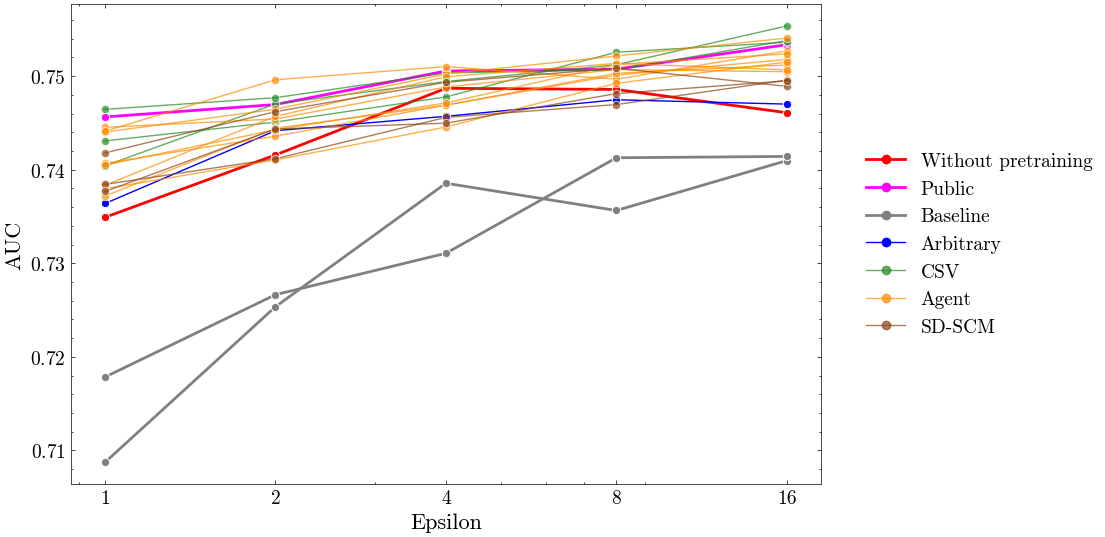

In [5]:
f, _, df = plot_metrics("acs", runs_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-dataset-acs.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


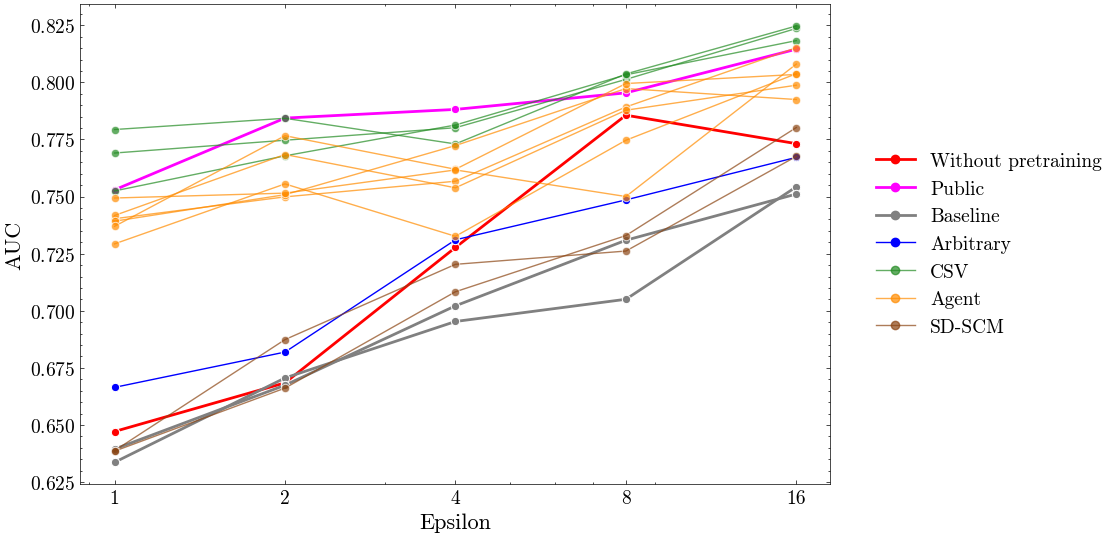

In [6]:
f, _, df = plot_metrics("edad", runs_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-dataset-edad.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


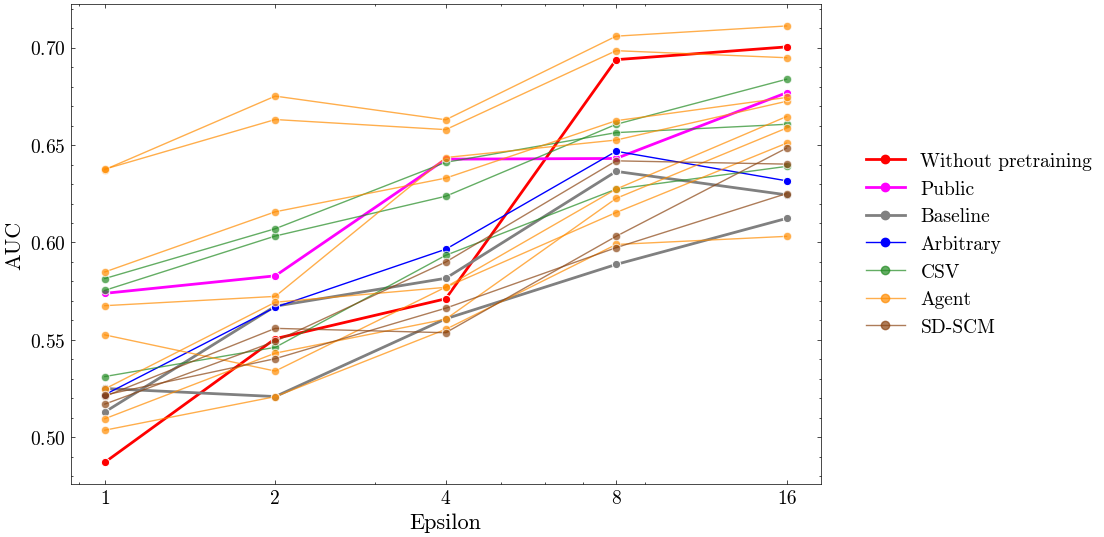

In [7]:
f, _, df = plot_metrics("we", runs_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-dataset-we.png", dpi=300)
df.to_clipboard()

## Mean - Category

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


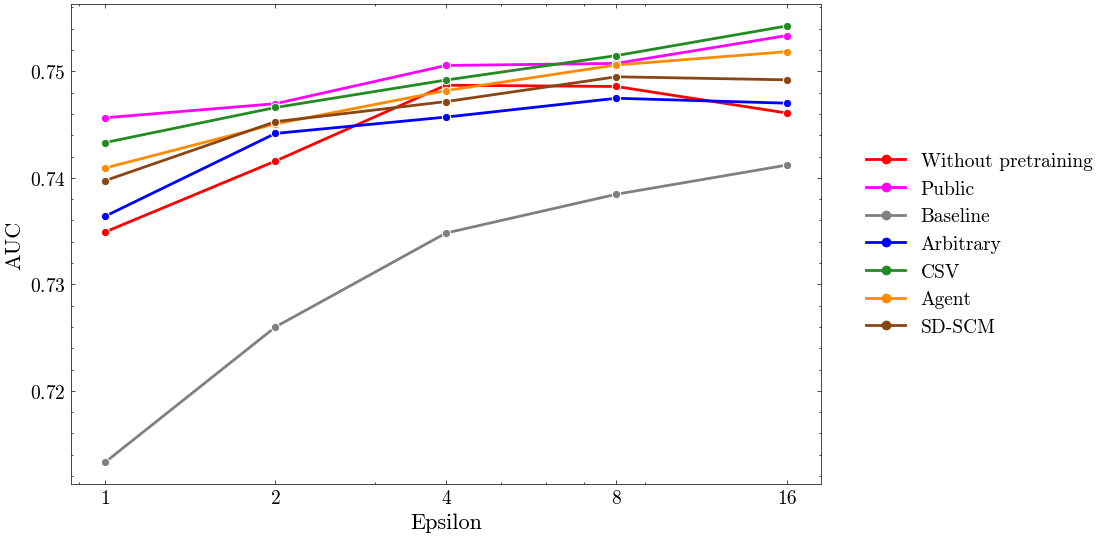

In [8]:
f, _, df = plot_metrics("acs", runs_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-category-acs.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


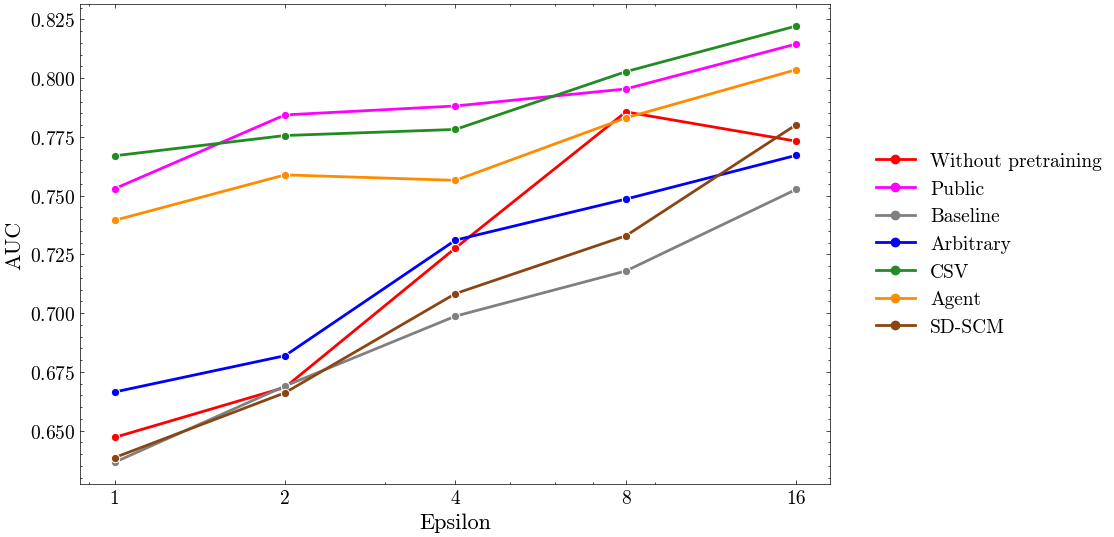

In [9]:
f, _, df = plot_metrics("edad", runs_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-category-edad.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


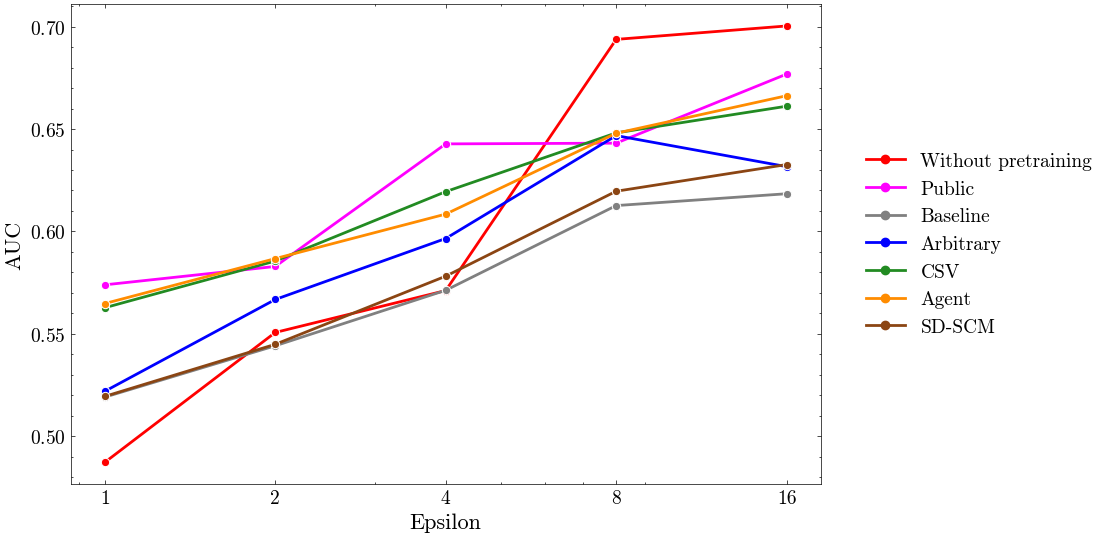

In [10]:
f, _, df = plot_metrics("we", runs_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-category-we.png", dpi=300)
df.to_clipboard()

## Choose best hparams on pre

In [11]:
idx = (
    runs_df.groupby(["epsilon", "public_data_pointer"] + [col for col in runs_df.columns if col.startswith("dp_")])
    ["pre/public.test/auc"]
    .idxmax()
    .dropna()
)

import pandas as pd

runs_best_on_pre_df = pd.concat([runs_df.loc[idx].reset_index(drop=True),
                                 runs_df.loc[runs_df["public_data_pointer"].str.contains("no-pre")]])

runs_best_on_pre_without_gpt2_df = runs_best_on_pre_df[~runs_best_on_pre_df["public_data_pointer"].str.contains("gpt2")]

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


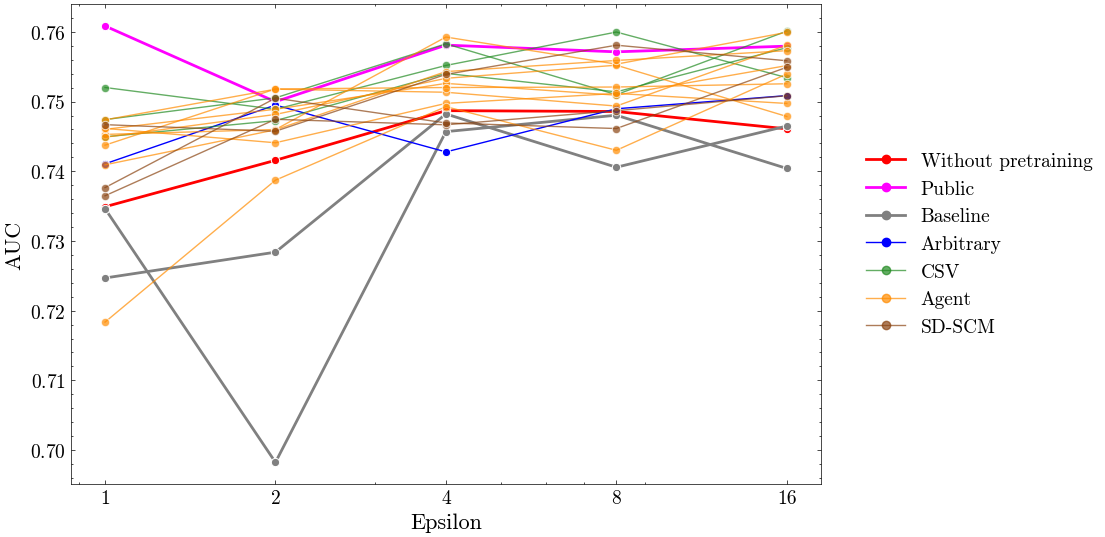

In [12]:
f, _, df = plot_metrics("acs", runs_best_on_pre_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-dataset-acs.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


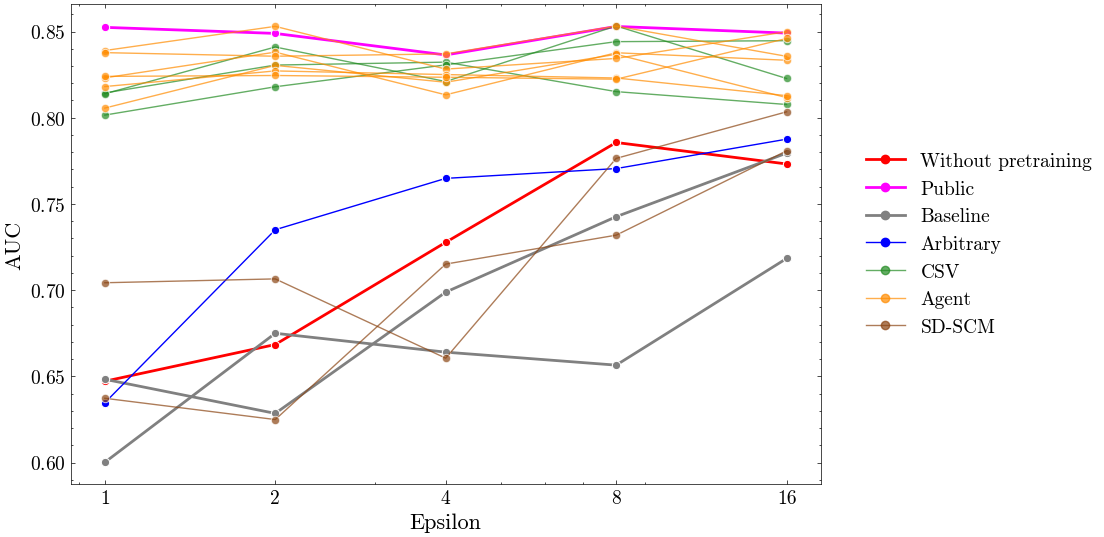

In [13]:
f, _, df = plot_metrics("edad", runs_best_on_pre_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-dataset-edad.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


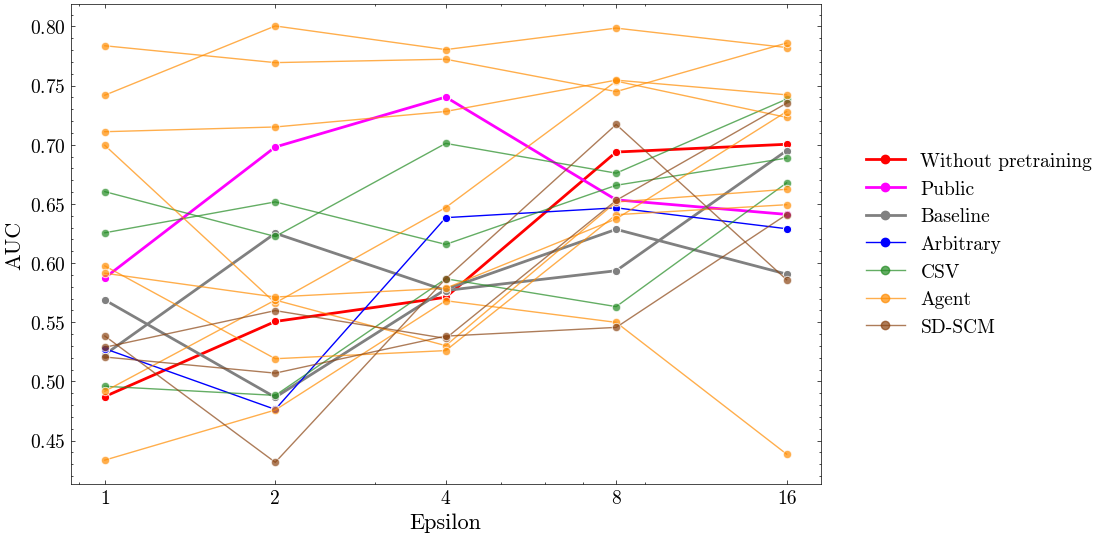

In [14]:
f, _, df = plot_metrics("we", runs_best_on_pre_df, viz_unit="dataset", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-dataset-we.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


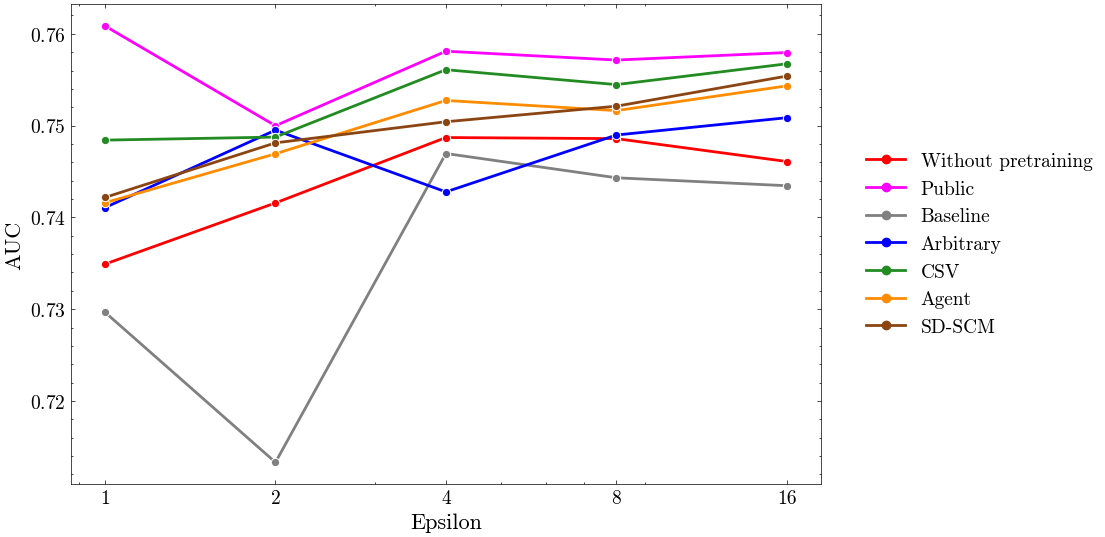

In [15]:
f, _, df = plot_metrics("acs", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-category-acs.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


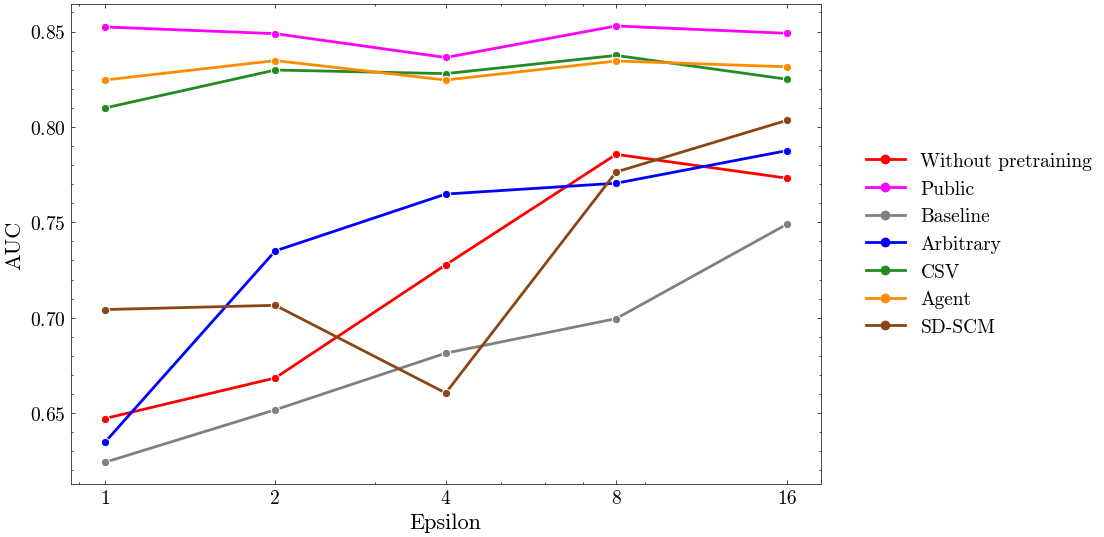

In [16]:
f, _, df = plot_metrics("edad", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-category-edad.png", dpi=300)
df.to_clipboard()

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_52610/3388899695.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


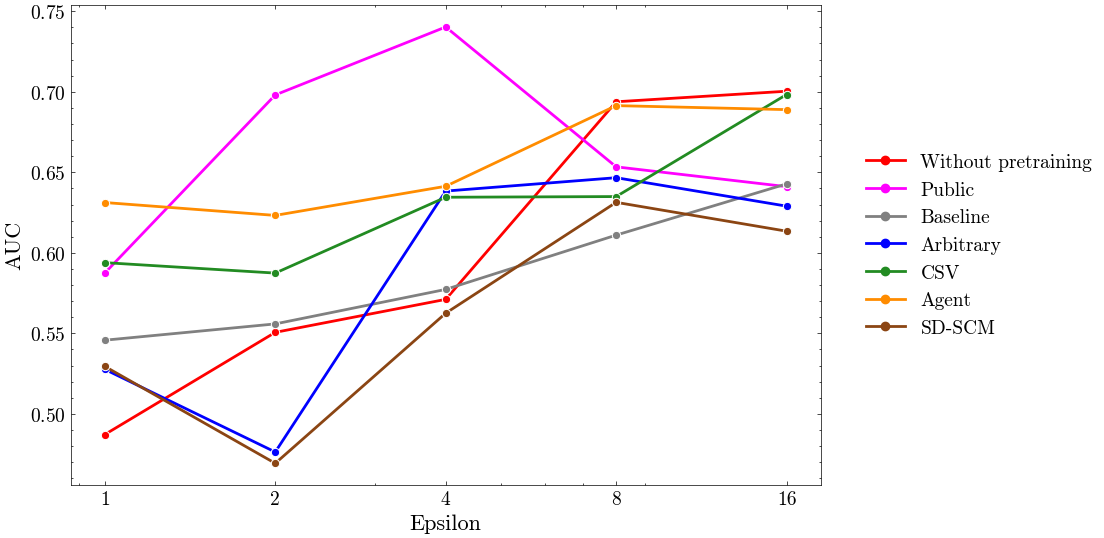

In [17]:
f, _, df = plot_metrics("we", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True)
f.savefig("./figs/pretraining-best-hparams-category-we.png", dpi=300)
df.to_clipboard()